# GPQA Diamond: Training Compute vs Performance Analysis

This notebook analyzes the relationship between training compute and GPQA Diamond performance over time.

**Research Question**: How much of the performance improvement is due to:
1. Increased training compute (scaling)
2. Algorithmic/architectural improvements (time after controlling for compute)

**Analysis**:
- Model 1: logit(score) ~ time (no compute control)
- Model 2: logit(score) ~ time + log(training_compute) (with compute control)

**Groups**:
1. **All models**: Every model in the dataset
2. **Frontier models**: Models that achieved better performance than any previous model

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 5)

## Load and Prepare Data

In [21]:
def logit(p):
    """Convert probability to logit scale"""
    p_clipped = np.clip(p, 0.001, 0.999)
    return np.log(p_clipped / (1 - p_clipped))

def inverse_logit(logit_val):
    """Convert logit back to probability"""
    return 1 / (1 + np.exp(-logit_val))

In [22]:
# Load data
df = pd.read_csv('data/gpqa_diamond.csv')

# Select relevant columns
df = df[['Model version', 'mean_score', 'Release date', 'Training compute (FLOP)']].copy()
df.columns = ['Model', 'Score', 'Release_Date', 'Training_Compute']

# Parse dates
df['Release_Date'] = pd.to_datetime(df['Release_Date'])

# Convert training compute to numeric (some might be missing)
df['Training_Compute'] = pd.to_numeric(df['Training_Compute'], errors='coerce')

# Filter to only models with valid scores, dates, and training compute
df_clean = df.dropna(subset=['Score', 'Release_Date', 'Training_Compute']).copy()
df_clean = df_clean[df_clean['Score'] > 0].copy()
df_clean = df_clean[df_clean['Training_Compute'] > 0].copy()

# Add transformations
df_clean['Score_logit'] = logit(df_clean['Score'])
df_clean['log_Training_Compute'] = np.log10(df_clean['Training_Compute'])

# Add time variables
min_date_ordinal = df_clean['Release_Date'].min().toordinal()
df_clean['Date_Ordinal'] = df_clean['Release_Date'].map(datetime.toordinal)
df_clean['Years_Since_Start'] = (df_clean['Date_Ordinal'] - min_date_ordinal) / 365.25

print(f"Total models with complete data: {len(df_clean)}")
print(f"Date range: {df_clean['Release_Date'].min()} to {df_clean['Release_Date'].max()}")
print(f"\nScore range: {df_clean['Score'].min():.3f} to {df_clean['Score'].max():.3f}")
print(f"Training compute range: {df_clean['Training_Compute'].min():.2e} to {df_clean['Training_Compute'].max():.2e} FLOP")

df_clean.head(10)

Total models with complete data: 52
Date range: 2023-03-14 00:00:00 to 2025-11-06 00:00:00

Score range: 0.147 to 0.870
Training compute range: 4.03e+23 to 5.00e+26 FLOP


,Model,Score,Release_Date,Training_Compute,Score_logit,log_Training_Compute,Date_Ordinal,Years_Since_Start
3,Qwen3-235B-A22B-Thinking-2507,0.8005,2025-07-25,4.7520e+24,1.3895,24.6769,739457,2.3655
4,openai/gpt-oss-120b_high,0.7576,2025-08-05,4.9400e+24,1.1394,24.6937,739468,2.3956
15,kimi-k2-thinking-turbo,0.8422,2025-11-06,4.2000e+24,1.6745,24.6232,739561,2.6502
18,gpt-5-2025-08-07_high,0.8617,2025-08-07,6.6000e+25,1.8298,25.8195,739470,2.4011
21,gpt-4-0314,0.3573,2023-03-14,2.1000e+25,-0.5870,25.3222,738593,0.0000
25,qwen3-max-2025-09-23,0.7260,2025-09-24,1.5120e+25,0.9745,25.1796,739518,2.5325
28,gpt-5-2025-08-07_medium,0.8535,2025-08-07,6.6000e+25,1.7626,25.8195,739470,2.4011
35,qwen3-235b-a22b,0.7071,2025-04-29,4.7520e+24,0.8812,24.6769,739370,2.1273
37,DeepSeek-R1-0528,0.7633,2025-05-28,4.0200e+24,1.1706,24.6042,739399,2.2067
38,claude-3-7-sonnet-20250219_64K,0.7850,2025-02-24,3.3500e+25,1.2953,25.5250,739306,1.9521


## Identify Frontier Models

Frontier models are those that achieved better performance than any model released before them.

In [23]:
# Sort by release date
df_sorted = df_clean.sort_values('Release_Date').copy()

# Identify frontier models
frontier_indices = []
max_score_so_far = -np.inf

for idx, row in df_sorted.iterrows():
    if row['Score'] > max_score_so_far:
        frontier_indices.append(idx)
        max_score_so_far = row['Score']

df_frontier = df_clean.loc[frontier_indices].copy()

print(f"Frontier models: {len(df_frontier)}")
print(f"All models: {len(df_clean)}")
print(f"\nFrontier models:")
print(df_frontier[['Model', 'Release_Date', 'Score', 'Training_Compute']].sort_values('Release_Date'))

Frontier models: 11
All models: 52

Frontier models:
                              Model Release_Date   Score  Training_Compute
21                       gpt-4-0314   2023-03-14  0.3573        2.1000e+25
131              mistral-large-2402   2024-02-26  0.3876        1.1200e+25
121       Meta-Llama-3-70B-Instruct   2024-04-18  0.4056        7.8610e+24
116              qwen2-72b-instruct   2024-06-07  0.4078        3.0200e+24
99       claude-3-5-sonnet-20240620   2024-06-20  0.5404        2.7000e+25
82                            phi-4   2024-12-12  0.5606        9.3202e+23
143                     DeepSeek-V3   2024-12-26  0.5653        3.4078e+24
40                      DeepSeek-R1   2025-01-20  0.6922        4.0200e+24
72   claude-3-7-sonnet-20250219_16K   2025-02-24  0.7677        3.3500e+25
38   claude-3-7-sonnet-20250219_64K   2025-02-24  0.7850        3.3500e+25
144                     grok-4-0709   2025-07-09  0.8700        5.0000e+26


## Regression Analysis

For each group (All models, Frontier models), we run:
- **Model 1**: logit(score) ~ time
- **Model 2**: logit(score) ~ time + log10(training_compute)

In [24]:
def run_regression_analysis(df, group_name):
    """Run regression analysis for a group"""
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_time_compute = df[['Years_Since_Start', 'log_Training_Compute']].values
    y_logit = df['Score_logit'].values
    n = len(y_logit)
    
    # Model 1: Without compute control
    model1 = LinearRegression().fit(X_time, y_logit)
    r2_1 = model1.score(X_time, y_logit)
    
    # Model 1 statistics
    residuals1 = y_logit - model1.predict(X_time)
    mse1 = np.sum(residuals1**2) / (n - 2)
    X_centered = X_time - np.mean(X_time)
    se1 = np.sqrt(mse1 / np.sum(X_centered**2))
    t_stat1 = model1.coef_[0] / se1
    p_value1 = 2 * (1 - stats.t.cdf(np.abs(t_stat1), n - 2))
    
    # Model 2: With compute control
    model2 = LinearRegression().fit(X_time_compute, y_logit)
    r2_2 = model2.score(X_time_compute, y_logit)
    
    # Model 2 statistics
    residuals2 = y_logit - model2.predict(X_time_compute)
    mse2 = np.sum(residuals2**2) / (n - 3)
    XtX_inv = np.linalg.inv(X_time_compute.T @ X_time_compute)
    se_coefs2 = np.sqrt(np.diag(XtX_inv) * mse2)
    t_stat2_time = model2.coef_[0] / se_coefs2[0]
    t_stat2_compute = model2.coef_[1] / se_coefs2[1]
    p_value2_time = 2 * (1 - stats.t.cdf(np.abs(t_stat2_time), n - 3))
    p_value2_compute = 2 * (1 - stats.t.cdf(np.abs(t_stat2_compute), n - 3))
    
    # Calculate coefficient change
    coef_change = model2.coef_[0] - model1.coef_[0]
    pct_change = (coef_change / model1.coef_[0]) * 100
    
    return {
        'Group': group_name,
        'N': n,
        'Time Coef (no control)': model1.coef_[0],
        'p-value': p_value1,
        'R² (no control)': r2_1,
        'Time Coef (w/ compute)': model2.coef_[0],
        'p-value (time)': p_value2_time,
        'Compute Coef': model2.coef_[1],
        'p-value (compute)': p_value2_compute,
        'R² (w/ compute)': r2_2,
        'Coef Δ': coef_change,
        'Coef Δ (%)': pct_change,
        'model1': model1,
        'model2': model2
    }

# Run analysis for both groups
results_all = run_regression_analysis(df_clean, 'All Models')
results_frontier = run_regression_analysis(df_frontier, 'Frontier Models')

# Create summary table
summary_data = [
    {k: v for k, v in results_all.items() if k not in ['model1', 'model2']},
    {k: v for k, v in results_frontier.items() if k not in ['model1', 'model2']}
]
summary_df = pd.DataFrame(summary_data)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 4)

print("\n" + "="*160)
print("GPQA DIAMOND: TRAINING COMPUTE ANALYSIS")
print("="*160 + "\n")
print(summary_df.to_string(index=False))

# Save results
summary_df.to_csv('results/gpqa_training_compute_regression.csv', index=False)
print("\n\nSaved to: results/gpqa_training_compute_regression.csv")


GPQA DIAMOND: TRAINING COMPUTE ANALYSIS

          Group  N  Time Coef (no control)    p-value  R² (no control)  Time Coef (w/ compute)  p-value (time)  Compute Coef  p-value (compute)  R² (w/ compute)  Coef Δ  Coef Δ (%)
     All Models 52                  1.2222 2.2204e-16           0.7413                  1.0167      0.0000e+00        0.4341         0.0000e+00           0.8509 -0.2055    -16.8122
Frontier Models 11                  1.0956 8.0137e-04           0.7306                  0.9853      9.1528e-05        0.4908         1.0617e-11           0.9111 -0.1103    -10.0707


Saved to: results/gpqa_training_compute_regression.csv


## Visualization: Performance Over Time

Shows observed trend (without compute control) vs compute-adjusted trend for both groups.

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_21350/1328196511.py:50: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_21350/1328196511.py:50: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.tight_layout()
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_21350/1328196511.py:51: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from current font.
  plt.savefig('figures/gpqa_training_compute_trends.png', dpi=300, bbox_inches='tight')
/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_21350/1328196511.py:51: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  plt.savefig('figures/gpqa_training_compute_trends.png', dpi=300, bbox_inches='tight')
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT 

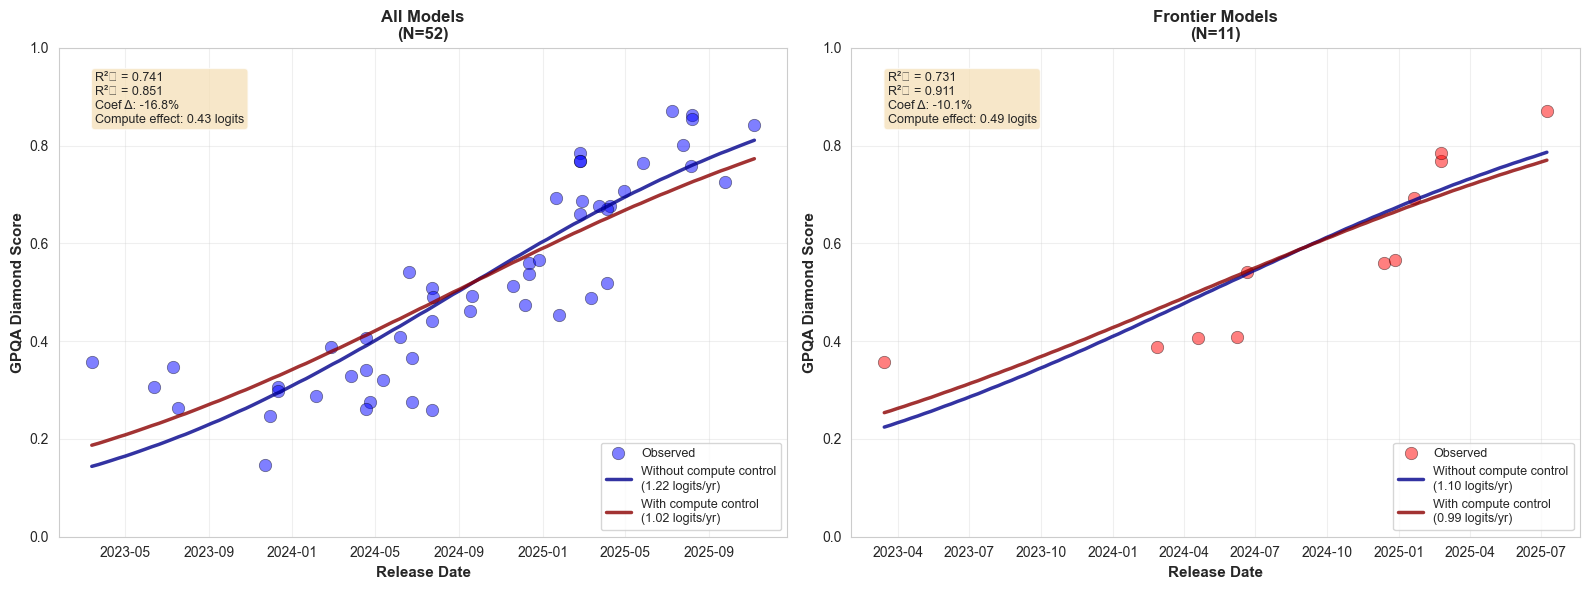


Interpretation:
Blue line: Observed trend (includes both algorithmic progress AND increased training compute)
Red line: Compute-adjusted trend (what we'd see if training compute stayed constant)

Gap between lines = contribution of increased training compute to progress


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    (df_clean, results_all, 'All Models', 'blue'),
    (df_frontier, results_frontier, 'Frontier Models', 'red')
]

for idx, (df, results, name, color) in enumerate(datasets):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df['Release_Date'], df['Score'], alpha=0.5, s=80, 
              color=color, edgecolors='black', linewidth=0.5, label='Observed')
    
    # Create prediction range
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    
    # Model 1: Without compute control
    pred1_logit = results['model1'].predict(years_range.values.reshape(-1, 1))
    pred1_score = inverse_logit(pred1_logit)
    ax.plot(dates_range, pred1_score, '-', color='darkblue', linewidth=2.5, 
           label=f'Without compute control\n({results["Time Coef (no control)"]:.2f} logits/yr)', alpha=0.8)
    
    # Model 2: With compute control (hold compute at mean)
    mean_log_compute = df['log_Training_Compute'].mean()
    X_pred2 = np.column_stack([years_range, np.full(len(years_range), mean_log_compute)])
    pred2_logit = results['model2'].predict(X_pred2)
    pred2_score = inverse_logit(pred2_logit)
    ax.plot(dates_range, pred2_score, '-', color='darkred', linewidth=2.5, 
           label=f'With compute control\n({results["Time Coef (w/ compute)"]:.2f} logits/yr)', alpha=0.8)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('GPQA Diamond Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\n(N={results["N"]})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Add stats box
    stats_text = f'R²₁ = {results["R² (no control)"]:.3f}\n'
    stats_text += f'R²₂ = {results["R² (w/ compute)"]:.3f}\n'
    stats_text += f'Coef Δ: {results["Coef Δ (%)"]:.1f}%\n'
    stats_text += f'Compute effect: {results["Compute Coef"]:.2f} logits'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/gpqa_training_compute_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("===============")
print("Blue line: Observed trend (includes both algorithmic progress AND increased training compute)")
print("Red line: Compute-adjusted trend (what we'd see if training compute stayed constant)")
print("\nGap between lines = contribution of increased training compute to progress")

## Training Compute Trends Over Time

Shows how training compute has changed over time for both groups.

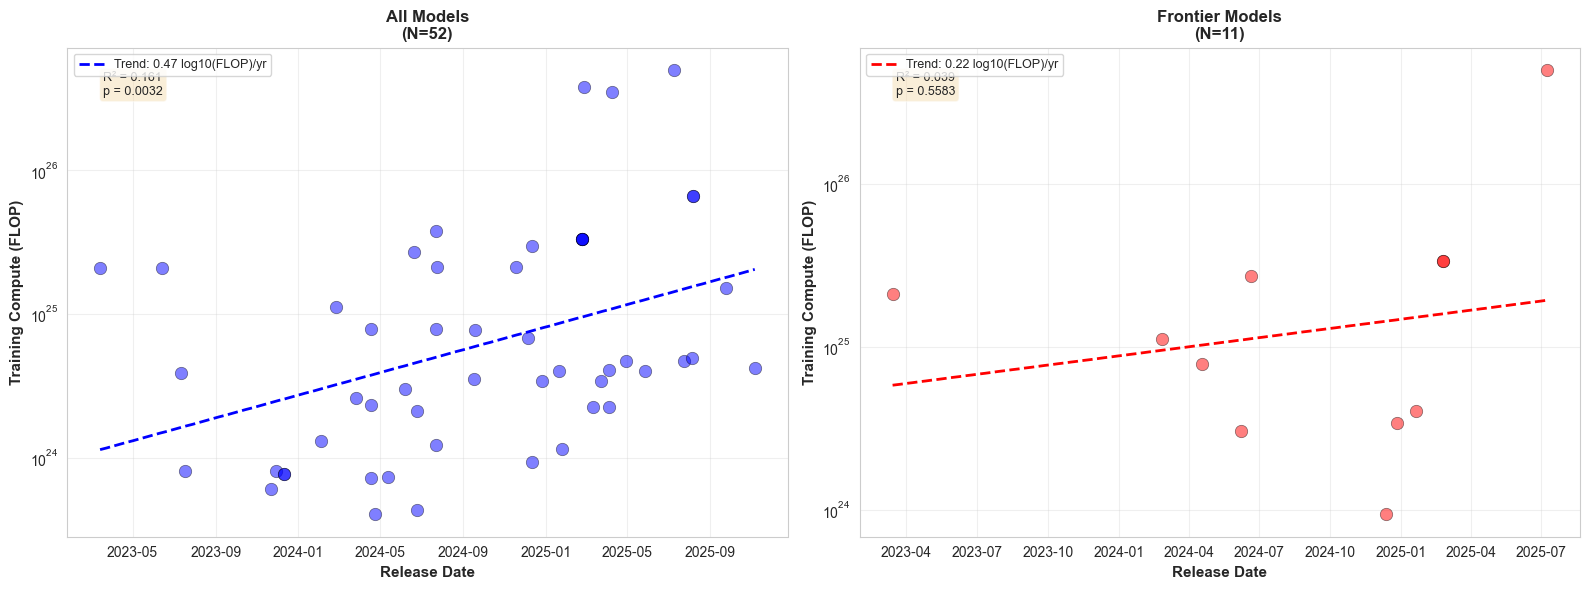

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    (df_clean, 'All Models', 'blue'),
    (df_frontier, 'Frontier Models', 'red')
]

for idx, (df, name, color) in enumerate(datasets):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(df['Release_Date'], df['Training_Compute'], alpha=0.5, s=80, 
              color=color, edgecolors='black', linewidth=0.5)
    
    # Fit regression: log10(Training_Compute) ~ Years
    X = df['Years_Since_Start'].values.reshape(-1, 1)
    y = df['log_Training_Compute'].values
    model = LinearRegression().fit(X, y)
    
    # Plot trend line
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    compute_pred = 10 ** model.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, compute_pred, '--', color=color, linewidth=2, 
           label=f'Trend: {model.coef_[0]:.2f} log10(FLOP)/yr')
    
    # Calculate statistics
    r_squared = model.score(X, y)
    n = len(y)
    residuals = y - model.predict(X)
    mse = np.sum(residuals**2) / (n - 2)
    X_centered = X - np.mean(X)
    se = np.sqrt(mse / np.sum(X_centered**2))
    t_stat = model.coef_[0] / se
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), n - 2))
    
    ax.set_yscale('log')
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Training Compute (FLOP)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\n(N={len(df)})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add stats box
    stats_text = f'R² = {r_squared:.3f}\np = {p_value:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('figures/gpqa_training_compute_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

## Binscatter-Style Visualization (Percentage Scale)

Shows observed vs compute-adjusted data points on the same graph.

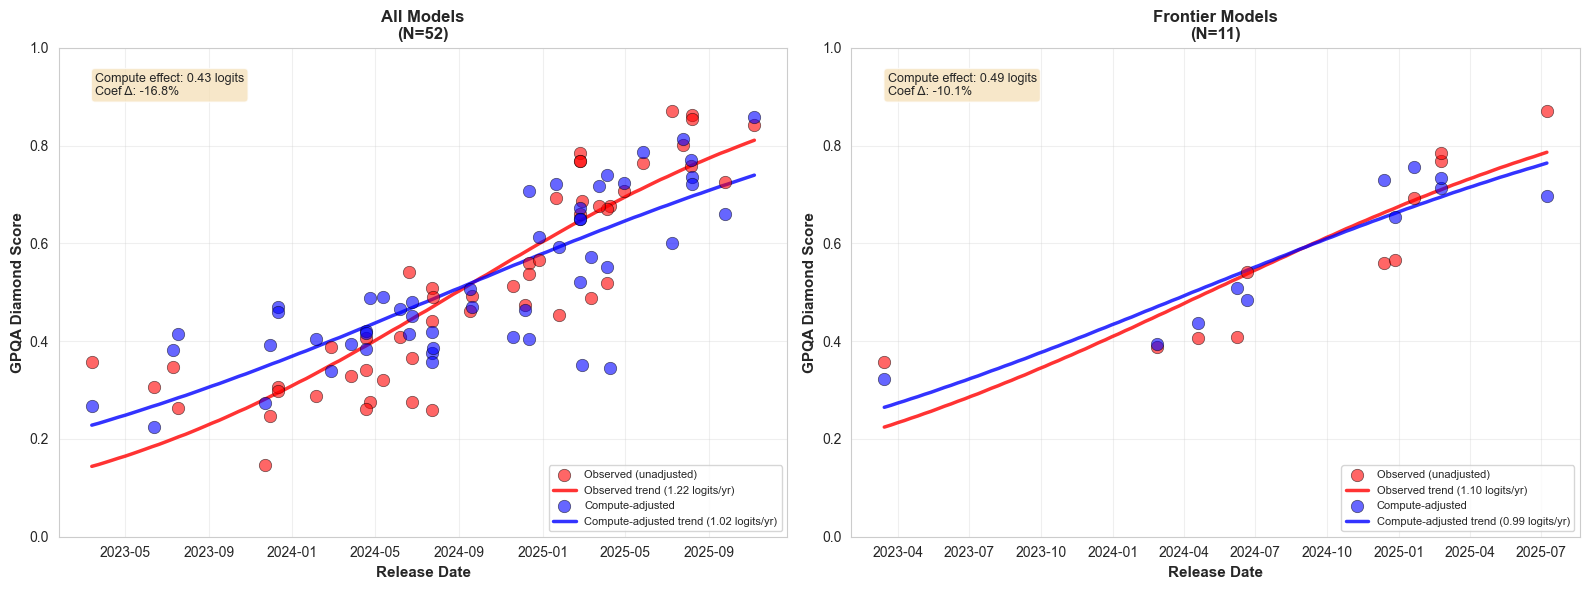


Interpretation:
Red points/line: What we observe (includes algorithmic progress AND increased training compute)
Blue points/line: What we'd see if training compute stayed constant (pure algorithmic progress)

Vertical distance between red and blue = effect of increased training compute over time


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    (df_clean, results_all, 'All Models'),
    (df_frontier, results_frontier, 'Frontier Models')
]

for idx, (df, results, name) in enumerate(datasets):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_compute = df['log_Training_Compute'].values.reshape(-1, 1)
    y_logit = df['Score_logit'].values
    
    # Calculate compute-residualized points
    model_compute_only = LinearRegression().fit(X_compute, y_logit)
    compute_effect = model_compute_only.predict(X_compute)
    y_residualized = y_logit - compute_effect + np.mean(y_logit)
    
    # Convert to percentage scale
    y_observed_pct = inverse_logit(y_logit)
    y_residualized_pct = inverse_logit(y_residualized)
    
    # Plot RAW data (RED)
    ax.scatter(df['Release_Date'], y_observed_pct, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    pred1_logit = results['model1'].predict(years_range.values.reshape(-1, 1))
    pred1_pct = inverse_logit(pred1_logit)
    ax.plot(dates_range, pred1_pct, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({results["Time Coef (no control)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot COMPUTE-ADJUSTED data (BLUE)
    ax.scatter(df['Release_Date'], y_residualized_pct, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Compute-adjusted', zorder=3)
    
    # Blue trend line
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    pred2_pct = inverse_logit(pred2_logit)
    ax.plot(dates_range, pred2_pct, '-', color='blue', linewidth=2.5, 
           label=f'Compute-adjusted trend ({results["Time Coef (w/ compute)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('GPQA Diamond Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\n(N={results["N"]})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    ax.set_ylim([0, 1])
    
    # Add stats box
    stats_text = f'Compute effect: {results["Compute Coef"]:.2f} logits\n'
    stats_text += f'Coef Δ: {results["Coef Δ (%)"]:.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/gpqa_binscatter_compute.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("===============")
print("Red points/line: What we observe (includes algorithmic progress AND increased training compute)")
print("Blue points/line: What we'd see if training compute stayed constant (pure algorithmic progress)")
print("\nVertical distance between red and blue = effect of increased training compute over time")

## Binscatter-Style Visualization (Logit Scale)

Same as above, but with y-axis in logits to show the linear regression relationships more clearly.

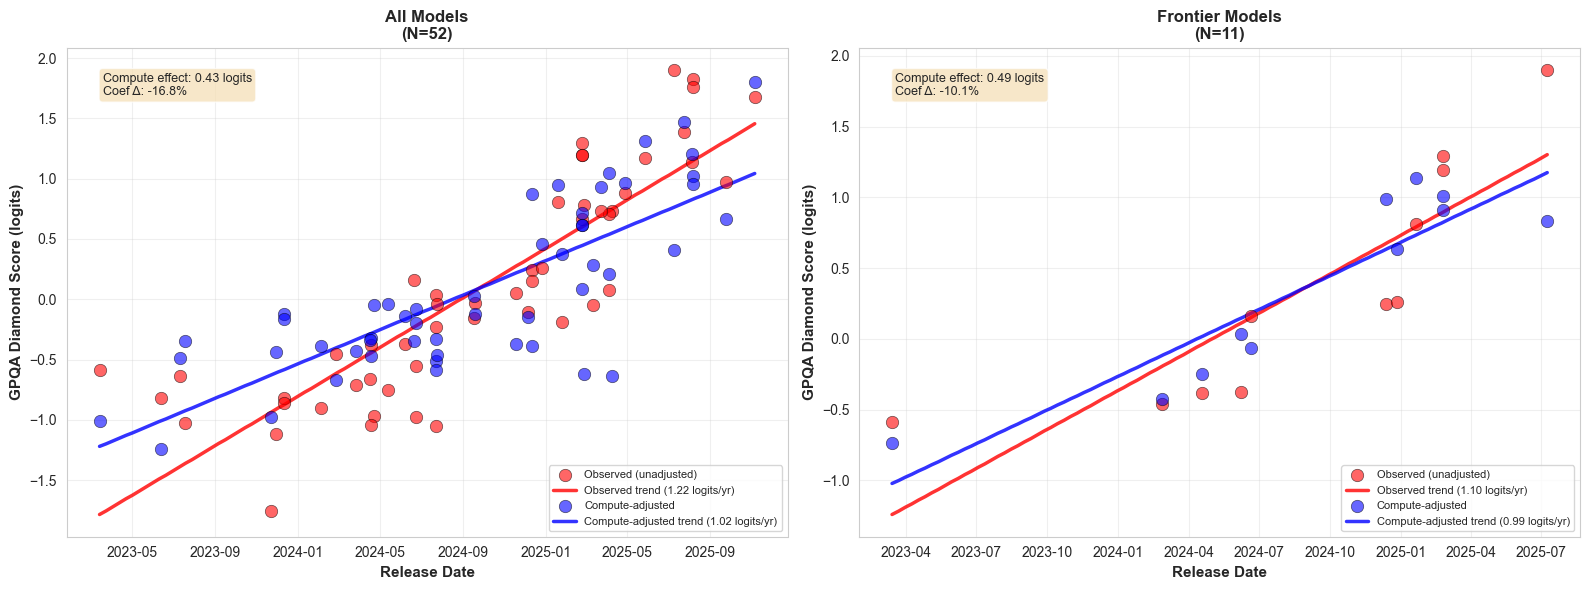


Interpretation:
Red points/line: What we observe (includes algorithmic progress AND increased training compute)
Blue points/line: What we'd see if training compute stayed constant (pure algorithmic progress)

Vertical distance between red and blue = effect of increased training compute over time

Logit scale makes the linear relationships in the regression model more apparent.


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    (df_clean, results_all, 'All Models'),
    (df_frontier, results_frontier, 'Frontier Models')
]

for idx, (df, results, name) in enumerate(datasets):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_compute = df['log_Training_Compute'].values.reshape(-1, 1)
    y_logit = df['Score_logit'].values
    
    # Calculate compute-residualized points
    model_compute_only = LinearRegression().fit(X_compute, y_logit)
    compute_effect = model_compute_only.predict(X_compute)
    y_residualized = y_logit - compute_effect + np.mean(y_logit)
    
    # Plot RAW data (RED) - IN LOGITS
    ax.scatter(df['Release_Date'], y_logit, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    pred1_logit = results['model1'].predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred1_logit, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({results["Time Coef (no control)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot COMPUTE-ADJUSTED data (BLUE) - IN LOGITS
    ax.scatter(df['Release_Date'], y_residualized, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Compute-adjusted', zorder=3)
    
    # Blue trend line
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred2_logit, '-', color='blue', linewidth=2.5, 
           label=f'Compute-adjusted trend ({results["Time Coef (w/ compute)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('GPQA Diamond Score (logits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\n(N={results["N"]})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Add stats box
    stats_text = f'Compute effect: {results["Compute Coef"]:.2f} logits\n'
    stats_text += f'Coef Δ: {results["Coef Δ (%)"]:.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/gpqa_binscatter_compute_logits.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("===============")
print("Red points/line: What we observe (includes algorithmic progress AND increased training compute)")
print("Blue points/line: What we'd see if training compute stayed constant (pure algorithmic progress)")
print("\nVertical distance between red and blue = effect of increased training compute over time")
print("\nLogit scale makes the linear relationships in the regression model more apparent.")

## Key Findings

### Comparison: All Models vs Frontier Models

**Time Coefficient Change:**
- Shows how much of the time trend is explained by increased training compute
- Large percentage change = strong confounding between time and training compute
- Small percentage change = time and training compute are relatively independent

**Training Compute Effect:**
- The coefficient on log10(training_compute) shows how much performance improves per 10x increase in training compute
- Higher coefficient = more sensitive to scaling

**R² Improvement:**
- The difference between R²₁ and R²₂ shows how much additional variance is explained by training compute
- Large improvement = training compute is a strong predictor beyond time alone

## Key Findings Across Benchmarks

### Understanding the Metrics:

**Time Coefficient Change (%)**:
- Measures how much of the observed time trend is explained by increased training compute
- Higher percentage = more confounding between time and training compute
- Lower percentage = time and training compute are relatively independent

**Training Compute Effect**:
- Shows performance improvement per 10x increase in training compute
- Measured in logits (log-odds units)
- Higher value = more sensitive to compute scaling

**R² Improvement**:
- Difference between R²(no control) and R²(w/ compute)
- Shows how much additional variance is explained by training compute
- Large improvement = training compute is a strong predictor beyond time alone

### Cross-Benchmark Patterns:

Compare the **Coef Δ (%)** column across benchmarks:
- **GPQA-D**: Shows how much progress is due to increased training compute vs algorithmic improvements
- **AIME**: Shows whether math reasoning benefits more from scaling or algorithms
- **SWE-Bench**: Shows whether coding performance is driven by compute or architecture

### Frontier vs All Models:

Comparing "All Models" vs "Frontier Models" within each benchmark reveals:
- Whether the broader model ecosystem follows the same scaling patterns as frontier models
- If algorithmic improvements are concentrated at the frontier or distributed across all models

In [29]:
# PLACEHOLDER - This cell will be moved to after all benchmark analyses are complete

# Cross-Benchmark Comparison

NameError: name 'swe_clean' is not defined

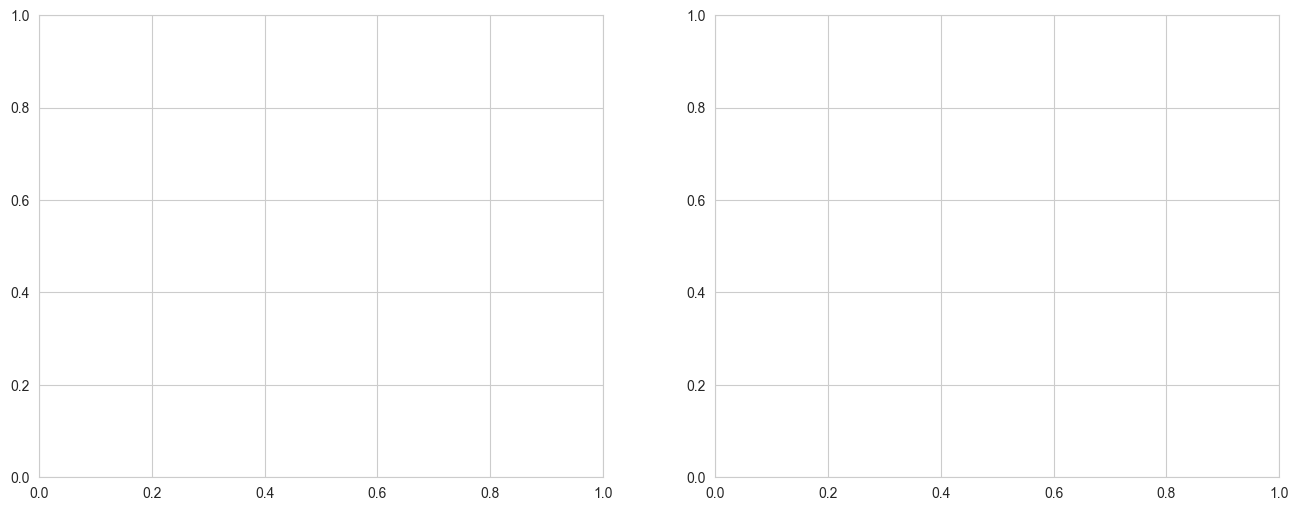

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets_swe = [
    (swe_clean, results_swe_all, 'SWE-Bench All Models'),
    (swe_frontier, results_swe_frontier, 'SWE-Bench Frontier Models')
]

for idx, (df, results, name) in enumerate(datasets_swe):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_compute = df['log_Training_Compute'].values.reshape(-1, 1)
    y_logit = df['Score_logit'].values
    
    # Calculate compute-residualized points
    model_compute_only = LinearRegression().fit(X_compute, y_logit)
    compute_effect = model_compute_only.predict(X_compute)
    y_residualized = y_logit - compute_effect + np.mean(y_logit)
    
    # Plot RAW data (RED) - IN LOGITS
    ax.scatter(df['Release_Date'], y_logit, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    pred1_logit = results['model1'].predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred1_logit, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({results["Time Coef (no control)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot COMPUTE-ADJUSTED data (BLUE) - IN LOGITS
    ax.scatter(df['Release_Date'], y_residualized, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Compute-adjusted', zorder=3)
    
    # Blue trend line
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred2_logit, '-', color='blue', linewidth=2.5, 
           label=f'Compute-adjusted trend ({results["Time Coef (w/ compute)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('SWE-Bench Score (logits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\\n(N={results["N"]})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Add stats box
    stats_text = f'Compute effect: {results["Compute Coef"]:.2f} logits\\n'
    stats_text += f'Coef Δ: {results["Coef Δ (%)"]:.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/swe_binscatter_compute_logits.png', dpi=300, bbox_inches='tight')
plt.show()

## SWE-Bench Binscatter Visualization (Logit Scale)

In [ ]:
# Identify frontier models for SWE-Bench
swe_sorted = swe_clean.sort_values('Release_Date').copy()
swe_frontier_indices = []
max_score_so_far = -np.inf

for idx, row in swe_sorted.iterrows():
    if row['Score'] > max_score_so_far:
        swe_frontier_indices.append(idx)
        max_score_so_far = row['Score']

swe_frontier = swe_clean.loc[swe_frontier_indices].copy()

print(f"SWE-Bench Frontier models: {len(swe_frontier)}")
print(f"SWE-Bench All models: {len(swe_clean)}")

# Run regression analysis
results_swe_all = run_regression_analysis(swe_clean, 'SWE-Bench All Models')
results_swe_frontier = run_regression_analysis(swe_frontier, 'SWE-Bench Frontier Models')

# Create summary table
summary_swe_data = [
    {k: v for k, v in results_swe_all.items() if k not in ['model1', 'model2']},
    {k: v for k, v in results_swe_frontier.items() if k not in ['model1', 'model2']}
]
summary_swe_df = pd.DataFrame(summary_swe_data)

print("\n" + "="*160)
print("SWE-BENCH: TRAINING COMPUTE ANALYSIS")
print("="*160 + "\n")
print(summary_swe_df.to_string(index=False))

# Append to results file
summary_swe_df.to_csv('results/swe_training_compute_regression.csv', index=False)
print("\n\nSaved to: results/swe_training_compute_regression.csv")

In [ ]:
# Select models with SWE-Bench scores and training compute
swe_df = merged_df[['Model', 'Release Date', 'epoch_swe', 'Training_Compute_FLOP']].copy()
swe_df.columns = ['Model', 'Release_Date', 'Score', 'Training_Compute']

# Clean data
swe_df['Release_Date'] = pd.to_datetime(swe_df['Release_Date'])
swe_df['Training_Compute'] = pd.to_numeric(swe_df['Training_Compute'], errors='coerce')
swe_df['Score'] = pd.to_numeric(swe_df['Score'], errors='coerce')

# Filter to valid data
swe_clean = swe_df.dropna(subset=['Score', 'Release_Date', 'Training_Compute']).copy()
swe_clean = swe_clean[swe_clean['Score'] > 0].copy()
swe_clean = swe_clean[swe_clean['Score'] < 1].copy()  # Remove 100% scores
swe_clean = swe_clean[swe_clean['Training_Compute'] > 0].copy()

# Add transformations
swe_clean['Score_logit'] = logit(swe_clean['Score'])
swe_clean['log_Training_Compute'] = np.log10(swe_clean['Training_Compute'])

# Add time variables
min_date_ordinal = swe_clean['Release_Date'].min().toordinal()
swe_clean['Date_Ordinal'] = swe_clean['Release_Date'].map(datetime.toordinal)
swe_clean['Years_Since_Start'] = (swe_clean['Date_Ordinal'] - min_date_ordinal) / 365.25

print(f"SWE-Bench models with complete data: {len(swe_clean)}")
print(f"Date range: {swe_clean['Release_Date'].min()} to {swe_clean['Release_Date'].max()}")
print(f"Score range: {swe_clean['Score'].min():.3f} to {swe_clean['Score'].max():.3f}")
print(f"Training compute range: {swe_clean['Training_Compute'].min():.2e} to {swe_clean['Training_Compute'].max():.2e} FLOP")

# SWE-Bench Training Compute Analysis

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets_aime = [
    (aime_clean, results_aime_all, 'AIME All Models'),
    (aime_frontier, results_aime_frontier, 'AIME Frontier Models')
]

for idx, (df, results, name) in enumerate(datasets_aime):
    ax = axes[idx]
    
    # Prepare data
    X_time = df['Years_Since_Start'].values.reshape(-1, 1)
    X_compute = df['log_Training_Compute'].values.reshape(-1, 1)
    y_logit = df['Score_logit'].values
    
    # Calculate compute-residualized points
    model_compute_only = LinearRegression().fit(X_compute, y_logit)
    compute_effect = model_compute_only.predict(X_compute)
    y_residualized = y_logit - compute_effect + np.mean(y_logit)
    
    # Plot RAW data (RED) - IN LOGITS
    ax.scatter(df['Release_Date'], y_logit, alpha=0.6, s=80, 
              color='red', edgecolors='black', linewidth=0.5, label='Observed (unadjusted)', zorder=3)
    
    # Red trend line
    dates_range = pd.date_range(df['Release_Date'].min(), df['Release_Date'].max(), periods=100)
    years_range = (dates_range - df['Release_Date'].min()).days / 365.25
    pred1_logit = results['model1'].predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred1_logit, '-', color='red', linewidth=2.5, 
           label=f'Observed trend ({results["Time Coef (no control)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    # Plot COMPUTE-ADJUSTED data (BLUE) - IN LOGITS
    ax.scatter(df['Release_Date'], y_residualized, alpha=0.6, s=80, 
              color='blue', edgecolors='black', linewidth=0.5, label='Compute-adjusted', zorder=3)
    
    # Blue trend line
    model_residualized = LinearRegression().fit(X_time, y_residualized)
    pred2_logit = model_residualized.predict(years_range.values.reshape(-1, 1))
    ax.plot(dates_range, pred2_logit, '-', color='blue', linewidth=2.5, 
           label=f'Compute-adjusted trend ({results["Time Coef (w/ compute)"]:.2f} logits/yr)', alpha=0.8, zorder=2)
    
    ax.set_xlabel('Release Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('AIME Score (logits)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\\n(N={results["N"]})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3, zorder=1)
    
    # Add stats box
    stats_text = f'Compute effect: {results["Compute Coef"]:.2f} logits\\n'
    stats_text += f'Coef Δ: {results["Coef Δ (%)"]:.1f}%'
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('figures/aime_binscatter_compute_logits.png', dpi=300, bbox_inches='tight')
plt.show()

## AIME Binscatter Visualization (Logit Scale)

In [ ]:
# Identify frontier models for AIME
aime_sorted = aime_clean.sort_values('Release_Date').copy()
aime_frontier_indices = []
max_score_so_far = -np.inf

for idx, row in aime_sorted.iterrows():
    if row['Score'] > max_score_so_far:
        aime_frontier_indices.append(idx)
        max_score_so_far = row['Score']

aime_frontier = aime_clean.loc[aime_frontier_indices].copy()

print(f"AIME Frontier models: {len(aime_frontier)}")
print(f"AIME All models: {len(aime_clean)}")

# Run regression analysis
results_aime_all = run_regression_analysis(aime_clean, 'AIME All Models')
results_aime_frontier = run_regression_analysis(aime_frontier, 'AIME Frontier Models')

# Create summary table
summary_aime_data = [
    {k: v for k, v in results_aime_all.items() if k not in ['model1', 'model2']},
    {k: v for k, v in results_aime_frontier.items() if k not in ['model1', 'model2']}
]
summary_aime_df = pd.DataFrame(summary_aime_data)

print("\n" + "="*160)
print("AIME: TRAINING COMPUTE ANALYSIS")
print("="*160 + "\n")
print(summary_aime_df.to_string(index=False))

# Append to results file
summary_aime_df.to_csv('results/aime_training_compute_regression.csv', index=False)
print("\n\nSaved to: results/aime_training_compute_regression.csv")

In [ ]:
# Load merged data with training compute
merged_df = pd.read_csv('data/merged_with_training_compute.csv')

# Select models with AIME scores and training compute
aime_df = merged_df[['Model', 'Release Date', 'epoch_AIME_nosamp', 'Training_Compute_FLOP']].copy()
aime_df.columns = ['Model', 'Release_Date', 'Score', 'Training_Compute']

# Clean data
aime_df['Release_Date'] = pd.to_datetime(aime_df['Release_Date'])
aime_df['Training_Compute'] = pd.to_numeric(aime_df['Training_Compute'], errors='coerce')
aime_df['Score'] = pd.to_numeric(aime_df['Score'], errors='coerce')

# Filter to valid data
aime_clean = aime_df.dropna(subset=['Score', 'Release_Date', 'Training_Compute']).copy()
aime_clean = aime_clean[aime_clean['Score'] > 0].copy()
aime_clean = aime_clean[aime_clean['Score'] < 1].copy()  # Remove 100% scores
aime_clean = aime_clean[aime_clean['Training_Compute'] > 0].copy()

# Add transformations
aime_clean['Score_logit'] = logit(aime_clean['Score'])
aime_clean['log_Training_Compute'] = np.log10(aime_clean['Training_Compute'])

# Add time variables
min_date_ordinal = aime_clean['Release_Date'].min().toordinal()
aime_clean['Date_Ordinal'] = aime_clean['Release_Date'].map(datetime.toordinal)
aime_clean['Years_Since_Start'] = (aime_clean['Date_Ordinal'] - min_date_ordinal) / 365.25

print(f"AIME models with complete data: {len(aime_clean)}")
print(f"Date range: {aime_clean['Release_Date'].min()} to {aime_clean['Release_Date'].max()}")
print(f"Score range: {aime_clean['Score'].min():.3f} to {aime_clean['Score'].max():.3f}")
print(f"Training compute range: {aime_clean['Training_Compute'].min():.2e} to {aime_clean['Training_Compute'].max():.2e} FLOP")

# AIME Training Compute Analysis

## Combined Results: All Benchmarks

Now that we've analyzed all three benchmarks, let's combine the results for comparison.

In [ ]:
# Combine all results into one table for comparison
all_results = []

# Add all groups
for result_dict, benchmark in [
    (results_all, 'GPQA-D'),
    (results_frontier, 'GPQA-D'),
    (results_swe_all, 'SWE-Bench'),
    (results_swe_frontier, 'SWE-Bench'),
    (results_aime_all, 'AIME'),
    (results_aime_frontier, 'AIME')
]:
    result_copy = {k: v for k, v in result_dict.items() if k not in ['model1', 'model2']}
    result_copy['Benchmark'] = benchmark
    all_results.append(result_copy)

comparison_df = pd.DataFrame(all_results)

# Reorder columns
column_order = ['Benchmark', 'Group', 'N', 'Time Coef (no control)', 'p-value', 'R² (no control)', 
                'Time Coef (w/ compute)', 'p-value (time)', 'Compute Coef', 'p-value (compute)', 
                'R² (w/ compute)', 'Coef Δ', 'Coef Δ (%)']
comparison_df = comparison_df[column_order]

print("\n" + "="*160)
print("TRAINING COMPUTE ANALYSIS: ALL BENCHMARKS COMPARISON")
print("="*160 + "\n")
print(comparison_df.to_string(index=False))

# Save combined results
comparison_df.to_csv('results/training_compute_comparison_all_benchmarks.csv', index=False)
print("\n\nSaved to: results/training_compute_comparison_all_benchmarks.csv")